In [126]:
import datetime
import tracemalloc

import numpy as np
from matplotlib import pyplot as plt

def grad(f, x, b, h=1e-4):
    return (f(x, b[:, np.newaxis] + h * np.eye(b.size)) - f(x, b[:, np.newaxis] - h * np.eye(b.size))) / (2 * h)

class GaussNewthonMethod():
    dimensions, current, v, result, points, batch_size, gamma, learning_rate, iteration = [None] * 9

    def init(self, x_data, y_data, batch_size, gamma, learning_rate):
        self.dimensions = x_data.shape[1]
        self.current = np.zeros(self.dimensions)
        self.result = self.current
        self.points = list(zip(x_data, y_data))
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.custom_init()

    def custom_init(self):
        pass

    def find_step(self, J, r, d = 0.5, eps = 1e-4):
        return -np.linalg.inv(np.transpose(J) @ J) @ np.transpose(J) @ r

    def approximate(self, f, dim, x_data, y_data, eps=1e-5, max_iter=1000):
        function = lambda b: y - f(x, b)

        b = np.ones(dim)

        s = None
        d = 1
        for i in range(max_iter):
            sn = 0
            for j in range(len(x_data)):
                x = x_data[j]
                y = y_data[j]
                sn += (function(b)) ** 2
            #print(s)
            if s is not None and abs(sn - s) < eps:
                print(i)
                break
            #print(s, sn)
            s = sn

            # J = np.empty((len(x_data), dim))
            # for j in range(len(x_data)):
            #     for z in range(dim):
            #         J[j][z] = -(x_data[j] ** (2 - z))
            J = []
            for j in range(len(x_data)):
                J.append(grad(f, x_data[j], b))
            J = np.array(J)
            J = -J
            #print(J)

            r = np.zeros(len(x_data))
            for j in range(len(x_data)):
                x = x_data[j]
                y = y_data[j]
                #print(function(b))
                r[j] = function(b)

            b = b + self.find_step(J, r, d)
            d *= 0.9
        return b

class DogLegMethod(GaussNewthonMethod):
    def find_step(self, J, r, d = 1, eps = 1e-5):
        gn = -np.linalg.inv(np.transpose(J) @ J) @ np.transpose(J) @ r
        sd = -np.transpose(J) @ r
        t = np.dot(sd, sd) / np.dot(J @ sd, J @ sd)
        tsd = t * sd
        if np.linalg.norm(gn) <= d:
            h = gn
        else:
            if np.linalg.norm(tsd) >= d:
                h = (d / np.linalg.norm(sd)) * sd
            else:
                l = 0
                r_g = 100
                while r_g - l > eps:
                    m = (r_g + l) / 2
                    if d > np.linalg.norm(tsd + m * (gn - tsd)):
                        l = m
                    else:
                        r_g = m
                h = tsd + r_g * (gn - tsd)
        return h

In [127]:
def polynom(x, b):
    return b[0] * (x ** 2) + b[1] * x + b[2]

def drf(x, b):
    return b[0] * x / (b[1] + x)

In [128]:
def draw(points, real_coeffs, predicted_coeffs, f):
    print("real_coeffs:", real_coeffs)
    print("predicted_coeffs:", predicted_coeffs)
    xses = points[0]
    yses = points[1]
    x = np.linspace(min(xses), max(xses), int(abs(max(xses) - min(xses))) * 100)
    y1 = [f(i, real_coeffs) for i in x]
    y2 = [f(i, predicted_coeffs) for i in x]
    plt.plot(x, y1, label='Real polynom')
    plt.plot(x, y2, label='Predicted polynom')
    plt.plot(xses, yses, 'go', label='Raw data')
    plt.legend()
    plt.show()

4
real_coeffs: [0.362, 0.556]
predicted_coeffs: [0.35998527 0.5515115 ]


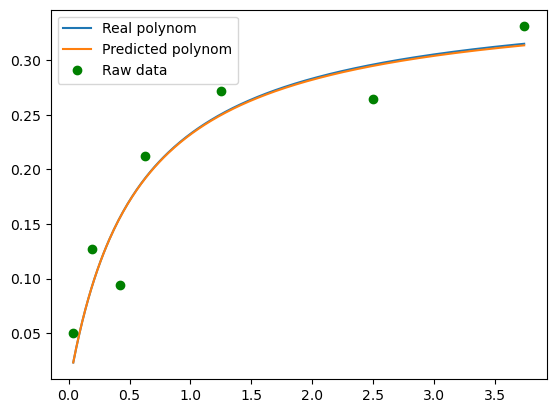

4
real_coeffs: [0.362, 0.556]
predicted_coeffs: [0.35998527 0.5515115 ]


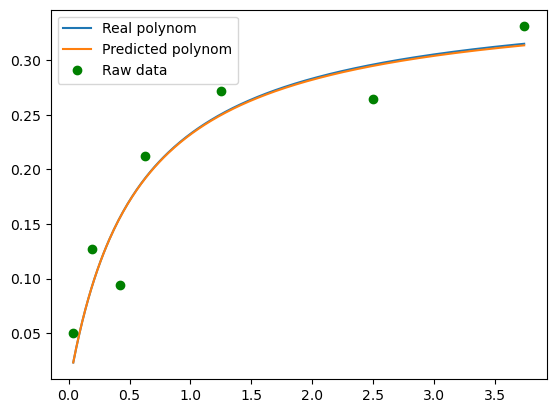

In [129]:
x = [0.038, 0.194, 0.425, 0.625, 1.253, 2.5, 3.74]
y = [0.05, 0.127, 0.094, 0.212, 0.272, 0.265, 0.331]
b = GaussNewthonMethod().approximate(drf, 2, x, y)
draw([x, y], [0.362, 0.556], b, drf)
b = DogLegMethod().approximate(drf, 2, x, y)
draw([x, y], [0.362, 0.556], b, drf)

In [132]:
def polynomial_regression(method, coeffs, points_amount=20):
    x_points = []
    y_points = []
    for i in range(points_amount):
        x_value = float((np.random.rand(1) - 0.5) * 4)
        y_value = np.polyval(coeffs, x_value)
        x_points.append(x_value)
        y_points.append(y_value)
    x_points = np.array(x_points)
    y_points = np.array(y_points)
    y_points += np.random.normal(0, 0.5, points_amount)
    tracemalloc.start()
    start = datetime.datetime.utcnow()
    b = method(polynom, 3, x_points, y_points)
    comp_time = (datetime.datetime.utcnow() - start).total_seconds()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f'computing_time: {comp_time}s, peak was {peak / 10**6}MB')
    draw([x_points, y_points], coeffs, b, polynom)

2
computing_time: 0.040018s, peak was 0.020451MB
real_coeffs: [0.5, -5, 0.8]
predicted_coeffs: [ 0.45532142 -5.12603001  0.85974443]


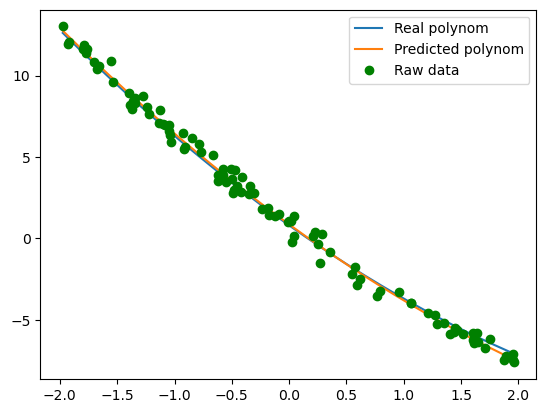

11
computing_time: 0.199474s, peak was 0.169303MB
real_coeffs: [0.5, -5, 0.8]
predicted_coeffs: [ 0.40803538 -4.98646853  0.9454279 ]


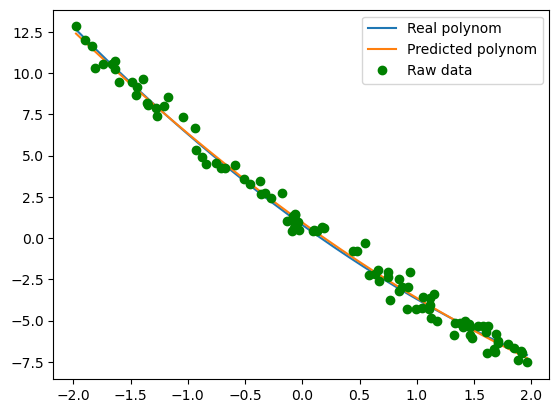

In [133]:
polynomial_regression(GaussNewthonMethod().approximate, [0.5, -5, 0.8], 100)
polynomial_regression(DogLegMethod().approximate, [0.5, -5, 0.8], 100)

In [98]:
print(np.polyval([0.5, -0.9, 0.8], 2))

1.0


In [118]:
print(np.random.normal(0, 3, 10))

[-0.60503744 -1.5238943   3.02178789 -5.05358813 -1.03869039  0.59965258
  0.78411698 -1.53360813  0.0122359   1.64515445]
